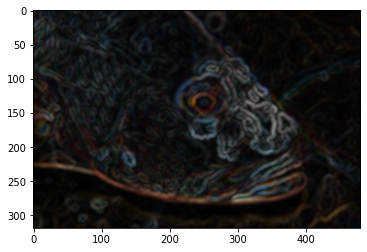

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img =mpimg.imread('/content/drive/MyDrive/Colab Notebooks/wavelet image segmentation/fish/fish1.jpg')
blur = cv2.GaussianBlur(img, (7, 7), 2)
h, w = img.shape[:2]

# Morphological gradient

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
plt.imshow(gradient)



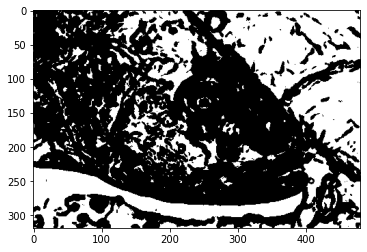

In [46]:
lowerb = np.array([0, 0, 0])
upperb = np.array([15, 15, 15])
binary = cv2.inRange(gradient, lowerb, upperb)
plt.imshow(binary, cmap = 'gray')

In [47]:
# binary1 = cv2.bitwise_and(binary2,binary2)	
# binary = cv2.bitwise_not(binary1)

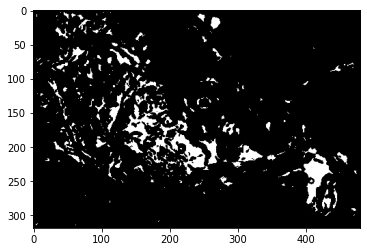

In [48]:
# Flood fill from the edges to remove edge crystals

for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)

for col in range(w):
    if binary[0, col] == 255:
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)

plt.imshow(binary, cmap ='gray')

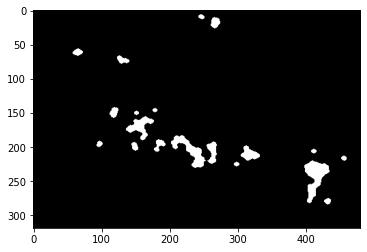

In [49]:
# Cleaning up mask

foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
plt.imshow(foreground, cmap = 'gray')


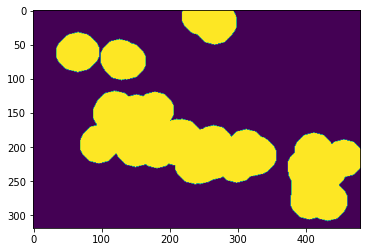

In [50]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
background = cv2.dilate(foreground, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)
plt.imshow(background)

In [51]:
markers = cv2.connectedComponents(foreground)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(img, markers)

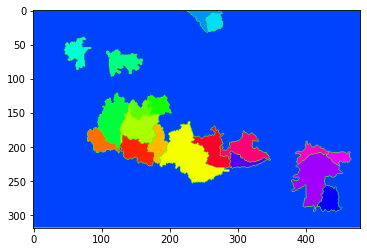

In [52]:
# Assign the markers a hue between 0 and 179

hue_markers = np.uint8(179*np.float32(markers)/np.max(markers))
blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)
plt.imshow(marker_img)

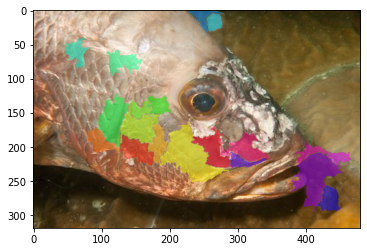

In [53]:
labeled_img = img.copy()
labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
labeled_img = cv2.addWeighted(img, 0.5, labeled_img, 0.5, 0)
plt.imshow(labeled_img)